In [1]:
import pandas as pd
import numpy as np
from utils import bootstrap, sigmoid, bootstrap_reg_new
from sklearn import metrics, calibration
from matplotlib import pyplot as plt
import math
import seaborn as sns

import numpy as np
from sklearn.metrics import roc_curve

/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [ ]:
regression = pd.read_csv(r'EF_predictions_regression.csv')
# bootstrap_reg_new()
bootstrap_reg_new(predictions[['EF_preds','EF_2D']])

In [25]:
# Classification Model Stats at the Youden Index
ef_35_binary = pd.read_csv(
    '/workspace/Amey/wandb_runs_and_manifests/wandb_runs/lvef_ekg_wandb/EF_binary_35/data/test_predictions.csv')
ef_35_binary.preds = ef_35_binary.preds.apply(sigmoid)
ef_35_binary['low_EF_binary'] = (ef_35_binary.EF_2D < 35) * 1
bootstrap(ef_35_binary.low_EF_binary, ef_35_binary.preds)


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (119,120,332,477,479,483,487,489,490,491,496,497,504,507,508,509,510) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# Regression Model Stats

# regression = pd.read_csv(r'EF_predictions_regression.csv')
regression = pd.read_csv('/workspace/Amey/wandb_runs_and_manifests/wandb_runs/lvef_ekg_wandb/lvef_31_days_stride8_dilation2/data/test_predictions.csv')
bootstrap_reg_new(regression[['EF_preds','EF_2D']])


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (119,120,332,477,479,483,487,489,490,491,496,497,504,507,508,509,510) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 10000/10000 [00:33<00:00, 300.84it/s]

AUC is 0.881 [0.874, 0.887]
Sensitivity is 0.407 [0.389, 0.424]
Specificity is 0.972 [0.97, 0.975]
PPV is 0.701 [0.68, 0.723]
NPV is 0.911 [0.907, 0.915]


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3397: DtypeWarning: Columns (119,120,332,477,479,483,487,489,490,491,496,497,504,507,508,509,510) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


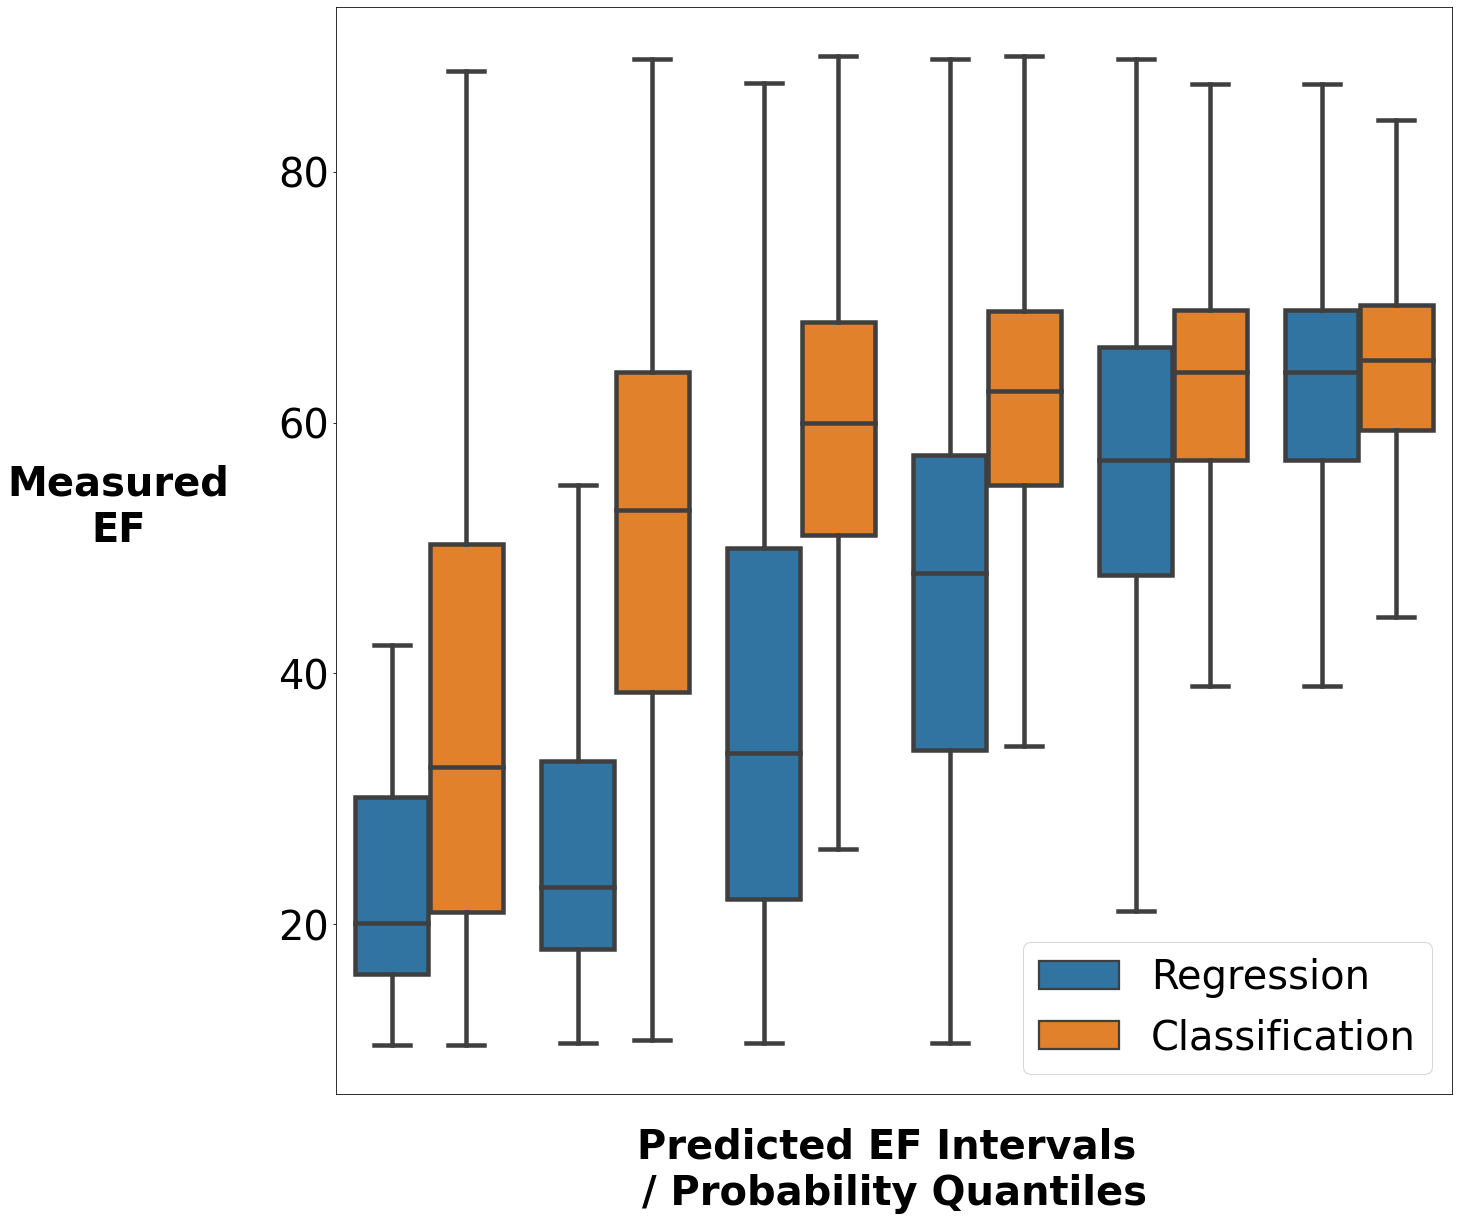

In [11]:
## Regression and Binary Models - 6 bins for Classification

predictions = pd.read_csv('/workspace/Amey/wandb_runs_and_manifests/wandb_runs/lvef_ekg_wandb/lvef_31_days_stride8_dilation2/data/test_predictions.csv')
labels_10 = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
predictions['EF_preds_bins'] = pd.cut(predictions.EF_preds, np.linspace(0,100,11), True, labels_10)
data_reg = pd.DataFrame()


for i in range(0,len(labels_10)):
    if i == 0:
        data_reg = pd.DataFrame(list(predictions[predictions.EF_preds_bins.isin([labels_10[i]])].EF_2D),
                                  columns = ['True_EF'])
        data_reg['quantile'] = labels_10[i]
        
    else:
        temp = pd.DataFrame(data = list(predictions[predictions.EF_preds_bins.isin([labels_10[i]])].EF_2D),
                            columns = ['True_EF'])
        temp['quantile'] = labels_10[i]
        data_reg = pd.concat([data_reg, temp], axis = 0)
        
data_reg['Model'] = 'Regression'

ef_35_binary = pd.read_csv('/workspace/Amey/wandb_runs_and_manifests/wandb_runs/lvef_ekg_wandb/EF_binary_35/data/test_predictions.csv')
ef_35_binary.preds = 1- ef_35_binary.preds.apply(sigmoid)
labels_10 = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
labels_6 = ['10-20','20-30','30-40','40-50','50-60','60-70']
ef_35_binary['EF_preds_bins'] = pd.cut(ef_35_binary.preds,
                                       np.quantile(ef_35_binary.preds,np.linspace(
                                           0,1,7)), True, labels_6)
data_binary = pd.DataFrame()

quantile_order = ['10-20','20-30','30-40','40-50','50-60','60-70']

for i in range(0,len(labels_6)):
    if i == 0:
        data_binary = pd.DataFrame(list(ef_35_binary[ef_35_binary.EF_preds_bins.isin([labels_6[i]])].EF_2D),
                                  columns = ['True_EF'])
        data_binary['quantile'] = labels_6[i]
        
    else:
        temp = pd.DataFrame(data = list(ef_35_binary[ef_35_binary.EF_preds_bins.isin([labels_6[i]])].EF_2D),
                            columns = ['True_EF'])
        temp['quantile'] = labels_6[i]
        data_binary = pd.concat([data_binary, temp], axis = 0)

data_binary['Model'] = 'Classification'

data = pd.concat([data_reg, data_binary])

fig = plt.figure(figsize=(20,20))
sns.boxplot(data=data, x = 'quantile', y = 'True_EF', hue = 'Model', order = quantile_order, width=0.8, showfliers=False, linewidth=4.5)
# sns.set(font_scale = 11)

plt.ylabel('True EF')
plt.xlabel('Predicted EF Intervals \n/ Probability Quantiles', size = 40,labelpad = 30, fontweight = 'bold')
plt.ylabel('Measured\nEF', size = 40, rotation = 0, labelpad = 160, fontweight = 'bold')
plt.legend(loc = 'lower right', fontsize = 40)
plt.xticks([],fontsize=100)
plt.yticks(np.linspace(20,80,4),fontsize=40, rotation=0)
plt.show()
